# Logistic Regression - Classification Model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_curve, roc_auc_score)
import os

os.makedirs("../data/processed", exist_ok=True)
os.makedirs("../figures", exist_ok=True)


In [3]:
df = pd.read_csv("../data/processed/telco_cleaned_encoded.csv")
print(df.shape)
df.head()

(7032, 41)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,True,False,False,True,False,False,False,False,True,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,True,False,False,False,True,False,False,False,False,True
2,1,0,0,0,2,1,1,53.85,108.15,1,...,True,False,False,True,False,False,False,False,False,True
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,True,False,False,False,True,False,True,False,False,False
4,0,0,0,0,2,1,1,70.70,151.65,1,...,True,False,False,True,False,False,False,False,True,False


## Train/Test Split

In [4]:
X = df.drop(columns=["Churn"])
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", len(X_train))
print("Test samples:", len(X_test))
print("Churn rate in train:", y_train.mean().round(3))
print("Churn rate in test:", y_test.mean().round(3))


Training samples: 5625
Test samples: 1407
Churn rate in train: 0.266
Churn rate in test: 0.266


## Feature Scaling

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Train the Logistic Regression Model

In [6]:
model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
model.fit(X_train_scaled, y_train)
print("Model trained.")


Model trained.


## Evaluate the Model

In [8]:
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.7263681592039801

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1033
           1       0.49      0.80      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407



In [9]:
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="accuracy")
print("Cross-validation scores:", cv_scores.round(3))
print("Mean CV accuracy:", cv_scores.mean().round(3))


Cross-validation scores: [0.736 0.773 0.753 0.735 0.765]
Mean CV accuracy: 0.753


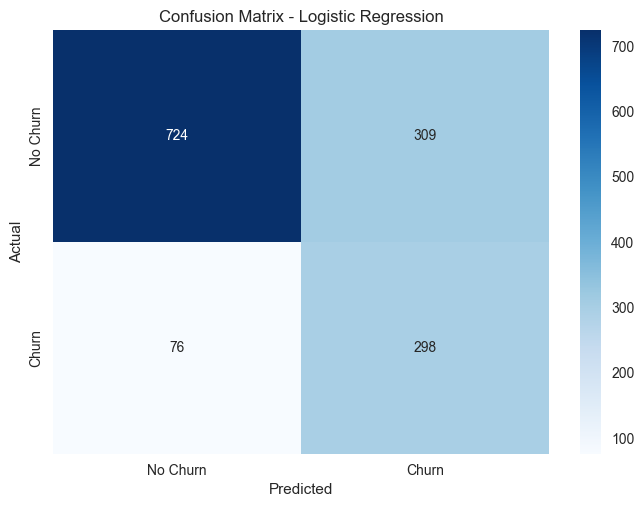

In [10]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Churn", "Churn"],
            yticklabels=["No Churn", "Churn"])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("../figures/07_confusion_matrix_lr.png")
plt.show()


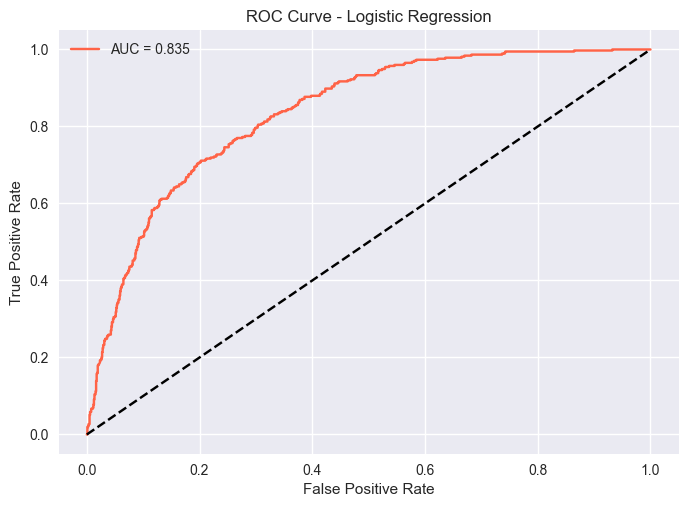

AUC Score: 0.8348


In [11]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", color="tomato")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig("../figures/08_roc_curve_lr.png")
plt.show()

print("AUC Score:", round(auc, 4))


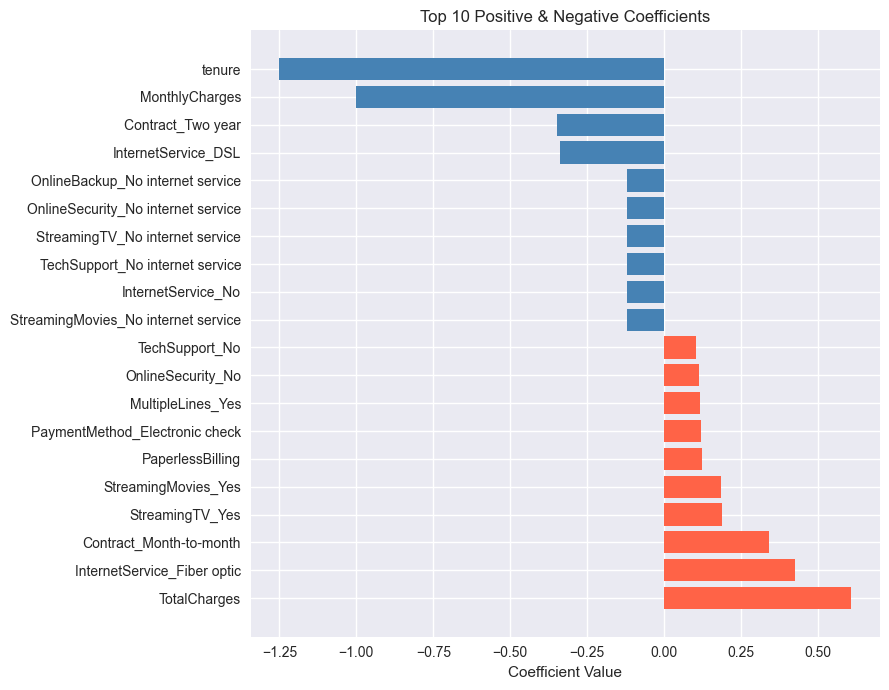

In [12]:
feature_names = X.columns.tolist()
coefficients = model.coef_[0]

coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
coef_df = coef_df.sort_values("Coefficient", ascending=False)

top10 = pd.concat([coef_df.head(10), coef_df.tail(10)])

plt.figure(figsize=(9, 7))
plt.barh(top10["Feature"], top10["Coefficient"],
         color=["tomato" if c > 0 else "steelblue" for c in top10["Coefficient"]])
plt.title("Top 10 Positive & Negative Coefficients")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.savefig("../figures/09_lr_coefficients.png")
plt.show()


In [13]:
proba_df = pd.DataFrame({"Churn_true": y_test.values, "Churn_proba": y_proba})
proba_df.to_csv("../data/processed/telco_logreg_test_proba.csv", index=False)

lr_results = {
    "model": "Logistic Regression (Classification)",
    "accuracy": accuracy_score(y_test, y_pred),
    "auc": auc
}
print("Saved probability results.")
print("LR Classification Results:", lr_results)


Saved probability results.
LR Classification Results: {'model': 'Logistic Regression (Classification)', 'accuracy': 0.7263681592039801, 'auc': 0.834836750858048}
